<a href="https://colab.research.google.com/github/TerryTian21/PyTorch-Practice/blob/main/Vegetable_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [103]:
# Check for GPU
!nvidia-smi

Wed Nov 15 18:59:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    42W / 300W |  16148MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [104]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.1.0+cu118


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. Increase model complexity - Adding more layers, increasing number of hidden units. Essentially giving model more opportunities to learn
2. Train for more epochs
3. Use feature crosses (feature engineering) or reduce regularization parameter
4. Incrase the quality and quanity of train data

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

The dataset we will be using is letter classification from https://raw.githubusercontent.com/MachineLearningBCAM/Datasets/main/data/multi_class_datasets/letter-recognition.csv

In [105]:
!pip install -q kaggle

In [106]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [107]:
! cp kaggle.json ~/.kaggle/

In [108]:
! chmod 600 ~/.kaggle/kaggle.json

In [109]:
! kaggle datasets download misrakahmed/vegetable-image-dataset

vegetable-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [110]:
! unzip vegetable-image-dataset.zip

Archive:  vegetable-image-dataset.zip
replace Vegetable Images/test/Bean/0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [111]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [112]:
from pathlib import Path
datapath = Path("Vegetable Images/")

walk_through_dir(datapath)

There are 3 directories and 0 images in 'Vegetable Images'.
There are 15 directories and 0 images in 'Vegetable Images/train'.
There are 0 directories and 1000 images in 'Vegetable Images/train/Cucumber'.
There are 0 directories and 1000 images in 'Vegetable Images/train/Pumpkin'.
There are 0 directories and 1000 images in 'Vegetable Images/train/Brinjal'.
There are 0 directories and 1000 images in 'Vegetable Images/train/Cauliflower'.
There are 0 directories and 1000 images in 'Vegetable Images/train/Broccoli'.
There are 0 directories and 1000 images in 'Vegetable Images/train/Tomato'.
There are 0 directories and 1000 images in 'Vegetable Images/train/Cabbage'.
There are 0 directories and 1000 images in 'Vegetable Images/train/Bitter_Gourd'.
There are 0 directories and 1000 images in 'Vegetable Images/train/Bean'.
There are 0 directories and 1000 images in 'Vegetable Images/train/Bottle_Gourd'.
There are 0 directories and 1000 images in 'Vegetable Images/train/Carrot'.
There are 0 dir

In [113]:
# Setup train and testing paths
train_dir = datapath / "train"
test_dir = datapath / "test"

In [114]:
# Visualize an image

import random
from PIL import Image

image_path_list = list(datapath.glob("*/*/*.jpg"))
image_path_list[:3]

[PosixPath('Vegetable Images/train/Cucumber/0656.jpg'),
 PosixPath('Vegetable Images/train/Cucumber/0415.jpg'),
 PosixPath('Vegetable Images/train/Cucumber/0444.jpg')]

Brinjal
Height : 224
Width: 224


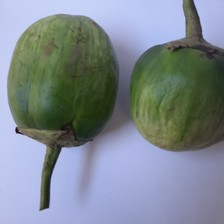

In [115]:
random_image = random.choice(image_path_list)

image_class = random_image.parent.stem

print(image_class)
img = Image.open(random_image)
print(f"Height : {img.height}")
print(f"Width: {img.width}")

img

(-0.5, 223.5, 223.5, -0.5)

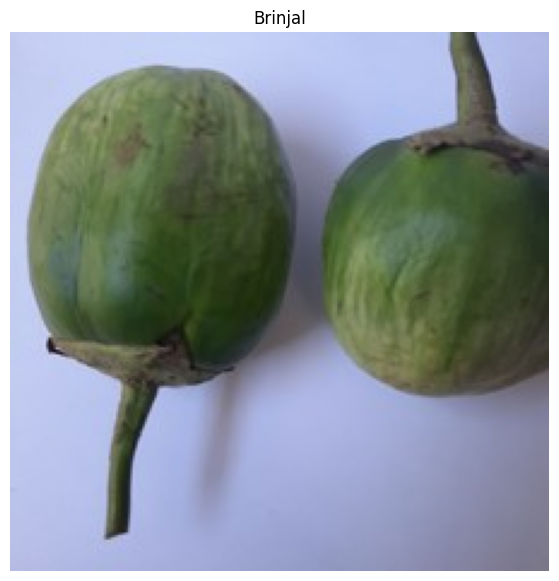

In [116]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

np_image = np.array(img)

plt.figure(figsize=(10,7))
plt.imshow(np_image)
plt.title(image_class)
plt.axis(False)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [117]:
# 3.1 Transforming data with torchvision.transforms
from torchvision.transforms import v2

In [118]:
np_image.shape

(224, 224, 3)

In [119]:
# Write transform for turning images into tensors

train_transformv0 = v2.Compose([v2.PILToTensor(),
                                v2.ToDtype(torch.float, scale=True),
                                v2.Resize(size=(64,64), antialias=None)
                              ])

train_transformv1 = v2.Compose([v2.PILToTensor(),
                              v2.ToDtype(torch.float, scale=True),
                              v2.TrivialAugmentWide(num_magnitude_bins=31),
                              ])

test_transform = v2.Compose([v2.PILToTensor(),
                             v2.ToDtype(torch.float, scale=True),
                             v2.Resize(size=(64,64), antialias=None)])

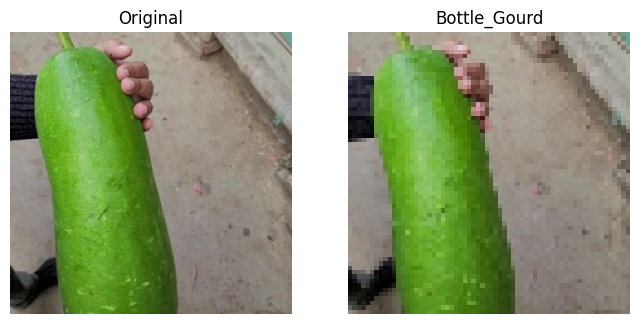

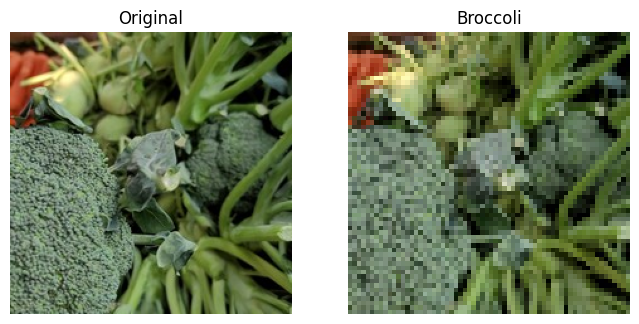

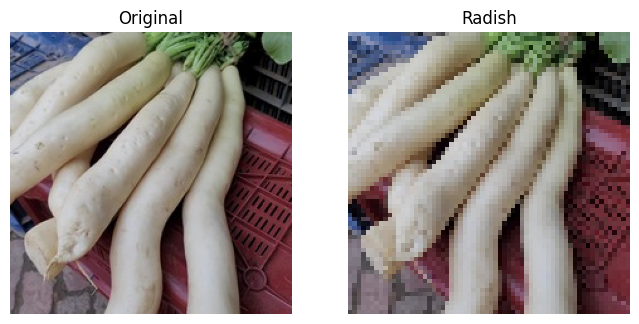

In [120]:
# Write a function to plot transformed images

def plot_images(image_path, n):
  """ Plots images against their transformed versions"""

  random_images = random.sample(image_path, n)
  for image in random_images:
    with Image.open(image) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,5))
      ax[0].imshow(f)
      ax[0].set_title("Original")
      ax[0].axis(False)

      p = random.random()
      if p > 0.5:
        ax[1].imshow(train_transformv0(f).permute(1,2,0))
      else:
        ax[1].imshow(train_transformv1(f).permute(1,2,0))
      ax[1].set_title("Transformed")
      ax[1].axis(False)

      plt.title(image.parent.stem)

plot_images(image_path_list, 3)

### Load image data using `ImageFolder`

In [121]:
# Use ImageFolder to create dataset(s)
from torchvision.datasets import ImageFolder

train_data = ImageFolder(root = "./Vegetable Images/train/",
                          transform=train_transformv0,
                          )

test_data = ImageFolder(root = "./Vegetable Images/test/",
                        transform=test_transform)

In [122]:
# Get class names as a list
class_names = train_data.classes
class_names

['Bean',
 'Bitter_Gourd',
 'Bottle_Gourd',
 'Brinjal',
 'Broccoli',
 'Cabbage',
 'Capsicum',
 'Carrot',
 'Cauliflower',
 'Cucumber',
 'Papaya',
 'Potato',
 'Pumpkin',
 'Radish',
 'Tomato']

In [123]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'Bean': 0,
 'Bitter_Gourd': 1,
 'Bottle_Gourd': 2,
 'Brinjal': 3,
 'Broccoli': 4,
 'Cabbage': 5,
 'Capsicum': 6,
 'Carrot': 7,
 'Cauliflower': 8,
 'Cucumber': 9,
 'Papaya': 10,
 'Potato': 11,
 'Pumpkin': 12,
 'Radish': 13,
 'Tomato': 14}

In [124]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(15000, 3000)

In [125]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers =NUM_WORKERS,
                             shuffle=False)

In [126]:
# How many batches of images are in our data loaders?
print(len(train_dataloader), len(test_dataloader))

235 47


## Try Creating a TinyVGG Model architecture

In [127]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.layer_stack1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2))
    self.layer_stack2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2))
    self.classification = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 10 * 16 * 16,
                  out_features = output_shape)
    )

  def forward(self, x):
    x = self.layer_stack1(x)
    x = self.layer_stack2(x)
    return self.classification(x)

In [243]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
HIDDEN_UNITS = 10

model_0 = TinyVGG(input_shape = 3,
                  output_shape = len(class_names),
                  hidden_units = HIDDEN_UNITS).to(device)

## 4. Create training and testing functions for `model_0`.

In [129]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for (X,y) in dataloader:
    # Send data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass

    y_logits = model(X)
    # 2. Calculate and accumulate loss
    loss = loss_fn(y_logits, y)
    train_loss += loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_preds = y_logits.softmax(dim=1).argmax(dim=1)
    train_acc += ((y_preds == y).sum().item() / len(y_preds))

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss, train_acc = train_loss / len(dataloader), train_acc / len(dataloader)

  return train_loss, train_acc

In [130]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():

    # Loop through DataLoader batches
    for (X,y) in dataloader:
      # Send data to target device
      X,y = X.to(device), y.to(device)

      # 1. Forward pass
      y_logits = model(X)

      # 2. Calculuate and accumulate loss
      test_loss += loss_fn(y_logits, y)

      # Calculate and accumulate accuracy
      y_preds = y_logits.softmax(dim=1).argmax(dim=1)
      test_acc += ((y_preds == y).sum().item() / len(y_preds))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss, test_acc = test_loss / len(dataloader), test_acc / len(dataloader)

  return test_loss, test_acc

In [131]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for different number of epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [221]:
# Try with a single input

batch, labels = next(iter(train_dataloader))

example = batch[0]
print(example.size())
example = example.unsqueeze(0)
print(example.size())
output = model_0(example.to(device))

print(output.size())
output_pred = output.softmax(dim=1).argmax(dim=1)
print(output_pred)
print(labels[0])

torch.Size([3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 15])
tensor([7], device='cuda:0')
tensor(1)


In [ ]:
!pip install torchmetrics

In [ ]:
# Create accuracy function
from torchmetrics.classification import MulticlassAccuracy

accuracy_fn = MulticlassAccuracy(num_classes=len(class_names)).to(device)

In [ ]:
print(len(class_names))

In [244]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

from timeit import default_timer as timer

start_time = timer()

results_m0_5ep = train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer)
end_time = timer()

print(f"Time Taken: {end_time - start_time}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9187 | train_acc: 0.3538 | test_loss: 1.1875 | test_acc: 0.6141
Epoch: 2 | train_loss: 1.0334 | train_acc: 0.6721 | test_loss: 0.9521 | test_acc: 0.6828
Epoch: 3 | train_loss: 0.7979 | train_acc: 0.7518 | test_loss: 0.7673 | test_acc: 0.7595
Epoch: 4 | train_loss: 0.6647 | train_acc: 0.7942 | test_loss: 0.6617 | test_acc: 0.7872
Epoch: 5 | train_loss: 0.5897 | train_acc: 0.8164 | test_loss: 0.5461 | test_acc: 0.8283
Time Taken: 34.09021586500057


In [215]:
import random

def get_predictions(model, test_dataloader, device):
  model.eval()
  predictions = []

  with torch.inference_mode():
    for (X,y) in test_dataloader:
      X, y = X.to(device), y.to(device)
      predictions.append(model(X).softmax(dim=1).argmax(dim=1))
  predictions = torch.cat(predictions, dim=0).cpu()
  return predictions

predictions = get_predictions(model_0, test_dataloader, device)


In [ ]:

def plot_predictions(model, test_data, predictions, device):

  plt.figure(figsize=(15, 6))

  for i in range(5):
    random_index = random.randint(0, len(test_data))
    plt.subplot(1, 5, i+1)

    plt.imshow(test_data[random_index][0].permute(1,2,0))
    plt.title(f"P: {class_names[predictions[random_index]]} | A: {class_names[test_data.targets[random_index]]}")
    plt.axis(False)

plot_predictions(model_0, test_data, predictions, device)

In [ ]:
results_m0_5ep["test_acc"]

In [ ]:
print(predictions[:20])
print(test_data.targets[:20])

diff = [1 if ae != be else -1 for ae, be in zip(predictions, test_data.targets)]
print(diff.count(1))
print(diff.count(1) / len(predictions))

In [ ]:
X, y = next(iter(test_dataloader))

X, y = X.to(device), y.to(device)

outs = model_0(X).softmax(dim=1).argmax(dim=1)
acc = accuracy_fn(outs, y)

print(f"{outs} \n {y}")

print(acc)
arr = outs.cpu().numpy()
print(np.count_nonzero(arr == 0))
print(len(arr))

In [ ]:
from torchmetrics.classification import MulticlassAccuracy

accuracy_fn=MulticlassAccuracy(num_classes=2).to(device)

t1 = torch.Tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]).to(device)
t2 = torch.Tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]).to(device)

print(accuracy_fn(t1, t2))

In [245]:
# Train for 10 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Create model
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_1 = TinyVGG(input_shape = 3,
                  output_shape = len(class_names),
                  hidden_units = HIDDEN_UNITS).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

start_time = timer()

results_m1_10ep = train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                        epochs=15)

end_time = timer()

print(f"Time Taken: {end_time - start_time}")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0503 | train_acc: 0.3285 | test_loss: 1.4475 | test_acc: 0.5300
Epoch: 2 | train_loss: 1.0645 | train_acc: 0.6629 | test_loss: 0.7815 | test_acc: 0.7485
Epoch: 3 | train_loss: 0.7224 | train_acc: 0.7741 | test_loss: 0.6573 | test_acc: 0.7851
Epoch: 4 | train_loss: 0.5700 | train_acc: 0.8225 | test_loss: 0.5915 | test_acc: 0.8110
Epoch: 5 | train_loss: 0.4524 | train_acc: 0.8607 | test_loss: 0.4816 | test_acc: 0.8493
Epoch: 6 | train_loss: 0.3824 | train_acc: 0.8836 | test_loss: 0.4790 | test_acc: 0.8525
Epoch: 7 | train_loss: 0.3382 | train_acc: 0.8993 | test_loss: 0.3880 | test_acc: 0.8850
Epoch: 8 | train_loss: 0.2969 | train_acc: 0.9100 | test_loss: 0.4072 | test_acc: 0.8774
Epoch: 9 | train_loss: 0.2570 | train_acc: 0.9236 | test_loss: 0.3633 | test_acc: 0.8932
Epoch: 10 | train_loss: 0.2324 | train_acc: 0.9305 | test_loss: 0.3934 | test_acc: 0.8879
Epoch: 11 | train_loss: 0.2023 | train_acc: 0.9395 | test_loss: 0.3750 | test_acc: 0.8981
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 7. Try using the Resnet Model Architecture and compare the model results

In [211]:
# Recreate Transforms

from torchvision.transforms import v2

new_transform = v2.Compose([v2.PILToTensor(),
                            v2.ToDtype(torch.float, scale=True),
                            v2.Resize(size=(224, 224), antialias=True)])

In [212]:
# Modify Data Inputs

train_data_new = ImageFolder(root = "./Vegetable Images/train/",
                          transform=new_transform
                          )

test_data_new = ImageFolder(root = "./Vegetable Images/test/",
                        transform=new_transform)

In [213]:
train_dataloader_new = DataLoader(dataset=train_data_new,
                                  batch_size=64,
                                  shuffle=True,
                                  num_workers=os.cpu_count())

test_dataloader_new = DataLoader(dataset=test_data_new,
                                  batch_size=64,
                                  shuffle=True,
                                  num_workers=os.cpu_count())

### Convolution Block

 We are going to start with a convolution block which is the first layer of our ResNet architecture. It consists of 4 operations

1. Convolution
2. Batch Normalization
3. ReLU Activation Function
4. Maxpooling

We have explored the previous operations with the exception of batch normalization.

**Batch Normalization** is a process that makes training NN more stable and efficient by re-centering and re-scaling. To explore further:

https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/

In [136]:
# Create a conv block

conv_block = nn.Sequential(
    nn.Conv2d(in_channels=3,
              out_channels=64, # Number of hidden units / neurons after first layer
              kernel_size=7,
              stride=2,
              padding=3,
              bias=False),
    nn.BatchNorm2d(num_features=64), # Specify the number of features
    nn.ReLU(inplace=True), # Inplace is set to true to conserve memeory but is discouraged
    nn.MaxPool2d(kernel_size = 3, stride =2, padding = 1)
)

conv_block

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)

In [137]:
# Here we create a sample input and pass it through the first layer checking input and output shapes

rand_tensor = torch.randn(3, 224, 224) # This matches the input shape
rand_tensor = rand_tensor.unsqueeze(dim=0)

print(f"Random Tensor Shape: {rand_tensor.shape}")

output = conv_block(rand_tensor)

print(f"Output Shape: {output.shape}")

Random Tensor Shape: torch.Size([1, 3, 224, 224])
Output Shape: torch.Size([1, 64, 56, 56])


### Residual Block

After two convolution operations, the input of those 2 convolutions are added to their output.

A **Residual Block** is a stack of layers set in such a way that the output of a layer is taken and added to another layer deeper in the block. The non-linearity is then applied after adding together with the output of the correspondign layer in the main path.

Stacking Serveral Residual blocks together forms a residual network.


### Basic Block

Each **basic block** consists of 2 convolution operations and each convolution layer is followed by a `batch normalization` and `ReLU` activation function.

The exception is when the downsample has to be applied, the 2nd layer's output is added to input before applying `ReLU`.

A `downsample` is simply reducing the dimensions of an input. For example if you have 16x16 input layer and apply a 2:1 downssample then you end up with a 8x8 output.

In [177]:
class BasicBlock(nn.Module):

  expansion = 1

  def __init__(self, inplanes, planes, stride=1, downsample=None):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Conv2d(in_channels=inplanes,
                  out_channels=planes,
                  kernel_size=3,
                  stride=stride,
                  padding=1,
                  bias=False),
        nn.BatchNorm2d(planes),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=planes,
                  out_channels=planes,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  bias=False),
        nn.BatchNorm2d(num_features=planes)
    )
    self.relu = nn.ReLU(inplace=True)
    self.downsample = downsample

  def forward(self, x):

    identity = x
    out = self.layer_stack(x)

    if self.downsample is not None:
      identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out

BasicBlock(inplanes=64,
           planes=128)


BasicBlock(
  (layer_stack): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU(inplace=True)
)

Using the training example we created earlier let's explore the output the the basic block.

Notice how the basic block doesn't change the shape of the input.

In [152]:
print(f"Input shape: {output.shape}")
print(f"Output shape: {BasicBlock(inplanes=64,planes=64)(output).shape}")

Input shape: torch.Size([1, 64, 56, 56])
torch.Size([1, 64, 56, 56])
Output shape: torch.Size([1, 64, 56, 56])


### `make_layer()`

The next 4 layers after the initial conv_block are called layer 1,2,3,4 respectively and each layer consists of mu;tiple convolution blocks. A `Conv_block` referes to the set of operations

* Convolution
* Batch Normalization
*ReLU

performed in the lsited order. Instead of adding new layers to create a deepr NN, resnet added multiple conv blocks wihtin each layer keep the depth to 4 layers.

In the PyTorch Implementation we distinguish the first block **basic block** from the other three blocks **bottleneck blocks** which contain 3 operations.

The make layer function takes

* which type of block to use as an argument
* The number of input and output filters
* The number of blocks to be stacked together and creates a layer

Every Layer downsamples the input at the start using strdie = 2 for 1st convolution layer in 1st block and stride = 1 for the rest.

In [153]:
def make_layer(block, inplanes, planes, blocks, stride=1):
  downsample = None

  if stride != 1 or inplanes != planes:
    downsample = nn.Sequential(
        nn.Conv2d(in_channels=inplanes,
                  out_channels=planes,
                  kernel_size=1,
                  stride=1,
                  bias=False),
        nn.BatchNorm2d(num_features=planes)
    )

  # Adding the blocks together
  layers = []
  layers.append(block(inplanes=inplanes,
                      planes=planes,
                      stride=stride,
                      downsample=downsample))
  inplanes = planes

  for _ in range(1, blocks):
    layers.append(block(inplanes=inplanes, planes=planes))

  return nn.Sequential(*layers) # Unpacks the values from an iterable

In [154]:
layers = [3,4,6,3]
layer1 = make_layer(BasicBlock, inplanes=64, planes=64, blocks=layers[0])
layer1

Sequential(
  (0): BasicBlock(
    (layer_stack): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU(inplace=True)
  )
  (1): BasicBlock(
    (layer_stack): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU(inplace=True)
  )
  (2): BasicBlock(
    (la

### Why do we need to downsize inputs

To apply convolution we need to have width and height dimensions of the 2 tensors to be the same.

In [155]:
rand_tensor2 = torch.randn(2, 64, 56, 56) # This is the output of the initial convolution layer
rand_tensor2.shape

torch.Size([2, 64, 56, 56])

In [156]:
output_tensor = nn.Conv2d(in_channels=64,
                          out_channels=128,
                          kernel_size=3,
                          stride=2,
                          padding=1)(rand_tensor2)
output_tensor.shape

torch.Size([2, 128, 28, 28])

In [157]:
# We will get an error when trying to concatenate the input tensor the the output tensor
# This is necessary for the residual step

output_tensor + rand_tensor2

RuntimeError: ignored

In [158]:
# Apply downsampling to get the correct input shapes

rand_tensor_downsample = nn.Conv2d(in_channels=64,
                                   out_channels=128,
                                   kernel_size=1,
                                   stride=2,
                                   padding=0)(rand_tensor2)

rand_tensor_downsample.shape, output_tensor.shape

(torch.Size([2, 128, 28, 28]), torch.Size([2, 128, 28, 28]))

### Classifier Block

This is a fully connected lyaer and the final layer in the resnet architecture. It consists of 3 operations

1. Average pooling layer - aggregates all features
2. Flatten - The loss function expects a vector of tensors tensors of rank 3 tensor
3. Linear Layer - A fully connected layer just before applying softmax which produces the desired number of output classes


`torch.nn.AvgPool2d` - Performs an average pool over an input signal. Similar to MaxPool, but takes the average of the kernel instead.

In [188]:
class ResNet(nn.Module):
  def __init__(self, input_shape, output_shape, hidden_units, block, layers):
    super().__init__()

    self.hidden_units = hidden_units

    # Create the initial conv layer
    self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=7,
                  stride=2,
                  padding=2,
                  bias=False),
        nn.BatchNorm2d(num_features = hidden_units),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

    # The main components of resnet

    self.layer1 = self.make_layer(block = block, planes = 64, blocks = layers[0])
    self.layer2 = self.make_layer(block = block, planes = 128, blocks = layers[1], stride=2)
    self.layer3 = self.make_layer(block = block, planes = 256, blocks = layers[2], stride=2)
    self.layer4 = self.make_layer(block = block, planes = 512, blocks = layers[3], stride=2)


    # Used for classification layer
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(in_features = 512, out_features=output_shape)

  def make_layer(self, block, planes, blocks, stride=1):
    downsample = None

    if stride != 1 or self.hidden_units != planes:

      downsample = nn.Sequential(
          nn.Conv2d(in_channels=self.hidden_units,
                    out_channels=planes,
                    kernel_size=1,
                    stride=2,
                    bias=False),
          nn.BatchNorm2d(planes)
      )

    layers = []

    layers.append(block(inplanes=self.hidden_units,
                      planes=planes,
                      stride=stride,
                      downsample=downsample))
    self.hidden_units = planes

    for _ in range(1, blocks):
      layers.append(block(inplanes=self.hidden_units, planes=planes))

    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv_layer(x) # Goes from 224 x 224 to 112 x 112
    x = self.layer1(x) # 56 x 56
    x = self.layer2(x) # 28 x 28
    x = self.layer3(x) # 14 x 14
    x = self.layer4(x) # 7 x 7
    x = self.avgpool(x) # 1x1
    x = torch.flatten(x, 1) # Remove the 1x1 grid and make vector of tensor shape
    x = self.fc(x)
    return x



In [160]:
def resnet34():
  layers = [3,4,6,3]
  model = ResNet(input_shape = 3,
                 output_shape = len(class_names),
                 hidden_units=64,
                 block=BasicBlock,
                 layers=layers)
  return model.to(device)

In [161]:
model_2 = resnet34()


None
Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### Train ResNet Model

In [186]:
!nvidia-smi
torch.cuda.empty_cache()

Wed Nov 15 19:14:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    43W / 300W |  16148MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [246]:
# Train Model
from timeit import default_timer as timer

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = resnet34()

EPOCHS = 10

# Create optimizer and loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(),
                             lr = 0.001)

# Call Train Function
start_time = timer()

results_m2_10ep = train(model=model_2,
                       train_dataloader=train_dataloader_new,
                       test_dataloader=test_dataloader_new,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                        epochs=10)

end_time = timer()

print(f"Time Taken : {end_time - start_time}")



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2802 | train_acc: 0.5793 | test_loss: 1.4297 | test_acc: 0.5310
Epoch: 2 | train_loss: 0.6429 | train_acc: 0.7940 | test_loss: 1.4950 | test_acc: 0.5968
Epoch: 3 | train_loss: 0.4363 | train_acc: 0.8629 | test_loss: 0.5780 | test_acc: 0.8218
Epoch: 4 | train_loss: 0.3239 | train_acc: 0.8971 | test_loss: 0.3701 | test_acc: 0.8663
Epoch: 5 | train_loss: 0.2323 | train_acc: 0.9259 | test_loss: 0.3216 | test_acc: 0.9001
Epoch: 6 | train_loss: 0.1797 | train_acc: 0.9442 | test_loss: 0.9093 | test_acc: 0.7866
Epoch: 7 | train_loss: 0.1686 | train_acc: 0.9491 | test_loss: 0.2544 | test_acc: 0.9244
Epoch: 8 | train_loss: 0.1211 | train_acc: 0.9624 | test_loss: 1.8893 | test_acc: 0.6562
Epoch: 9 | train_loss: 0.1232 | train_acc: 0.9621 | test_loss: 0.7722 | test_acc: 0.7922
Epoch: 10 | train_loss: 0.1037 | train_acc: 0.9661 | test_loss: 0.2053 | test_acc: 0.9400
Time Taken : 297.2109356719993


In [216]:
# Compare Results Between Models

def get_test_results(model, dataloader, loss_fn):
  model.eval()
  loss, acc = 0, 0
  with torch.inference_mode():
    for (X, y) in dataloader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y).item()
      acc += (y_pred.argmax(dim=1) == y).sum().item()
  loss /= len(dataloader)
  acc /= len(dataloader.dataset)
  return loss, acc


In [219]:
loss, acc = get_test_results(model_2, test_dataloader_new, loss_fn)
loss, acc

(0.187000452917307, 0.9406666666666667)

In [247]:
lst = [results_m0_5ep, results_m1_10ep, results_m2_10ep]

for result in lst:
  result['train_loss'] = [x.cpu().detach() for x in result['train_loss']]
  result['test_loss'] = [x.cpu().detach() for x in result['test_loss']]


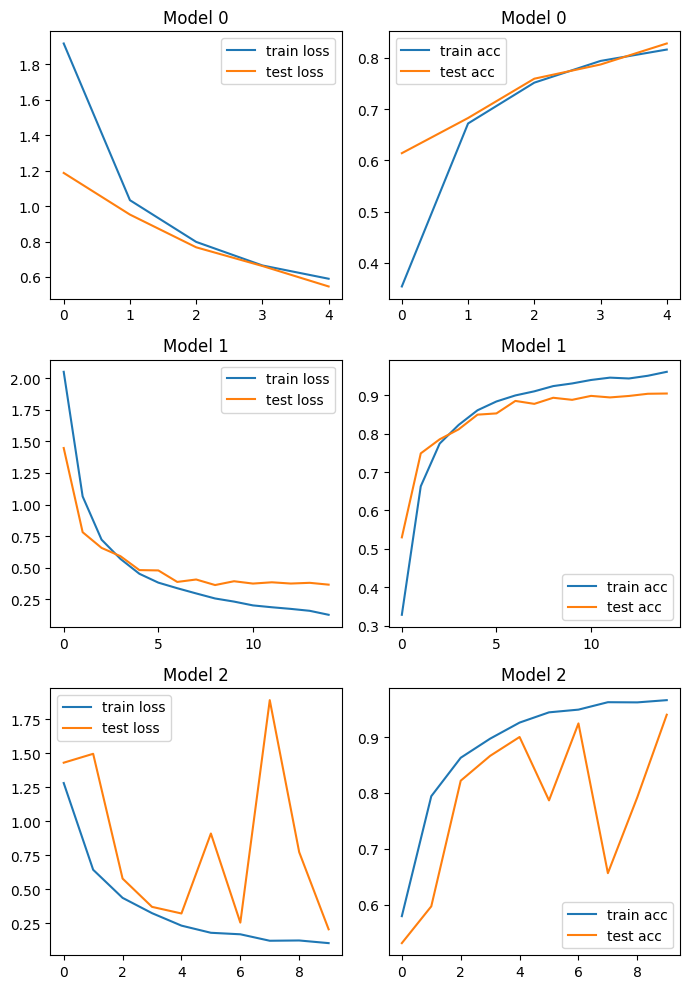

In [249]:
### Visualize the results of different models
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,2)
fig.set_size_inches(7, 10)


for index, result in enumerate(lst):
  ax[index, 0].plot(result['train_loss'], label='train loss')
  ax[index, 0].plot(result['test_loss'], label='test loss')
  ax[index, 0].set_title(f"Model {index}")
  ax[index, 0].legend()

  ax[index, 1].plot(result['train_acc'], label='train acc')
  ax[index, 1].plot(result['test_acc'], label='test acc')
  ax[index, 1].set_title(f"Model {index}")
  ax[index, 1].legend()

fig.tight_layout()

## 8. Make a prediction on your own custom image of a vegetable

* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?